# Imágenes Biomédicas. Tarea 3.
### Diseño de descriptores usando una metaheurística.

**Diego Moreno**

En este reporte se habla acerca de los resultados obtenidos para la detección de bordes usando como base las ideas de los filtros Gaussianos. En este método se generan filtros de tamaño T=13, con varianza para la función Gaussiana de 2 y los filtros son rotados con una resolución de 15 grados para detectar las arteriar en cierta dirección. Con cada filtro, se realiza una centralización de los mismo para posteriormente hacer convoluciones en la imagen a detectar los bordes; quedandose así, con el filtro que tenga un mayor valor en la convolución. De esta manera, se pondrá el mayor valor en el píxel central de la convolución. Como resultado se espera una imagen con los bordes o arteriar resaltadas.

En la primera parte, se usan las imágenes de la base de datos de http://personal.cimat.mx:8181/~ivan.cruz/Databases.html, y en la segunda parte la base de datos de la retina. Para los datos de la retina, se convierte cada imagen a escala de grises para así lograr detectar los bordes al trabajar con ellas.

Al final del reporte se habla respecto a las conclusiones.

Importamos las librerías:

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib import transforms
import numba
import cv2
import PIL

Filtro Gaussiano:

In [2]:
def GMF(T=13, sg=2, k=255, angle=0):
    '''
    Función que crea un filtro gaussiano de tamaño TxT
    '''
    # Filtro Gaussiano
    x = np.array([-(T//2)+i for i in range(T)])
    tmp = np.exp(-(x**2) / (2*sg**2))
    fil = [-tmp*k for i in range(T)]
    
    # Rotación
    rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    fil_rot = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            idx = rot@[j-(T//2),i-(T//2)]
            X = int(idx[1] + T//2 +.5)
            Y = int(idx[0] + T//2 +.5)
            
            if X<T and X>=0 and Y<T and Y>=0:
                fil_rot[Y][X] = fil[j][i]
    # Relleno
    for i in range(T):
        for j in range(T):
            if fil_rot[i][j] == 0:
                suma = 0
                size = 0
                if i-1>0:
                    suma += fil_rot[i-1][j]
                    size += 1
                if j-1>0:
                    suma += fil_rot[i][j-1]
                    size += 1
                if i+1<T:
                    suma += fil_rot[i+1][j]
                    size += 1
                if j+1<T:
                    suma += fil_rot[i][j+1]
                    size += 1
                suma /= size
                fil_rot[i][j] = suma
    # Media del kernel
    m = sum(sum(fil_rot))/T**2
    # Filtro Gaussiano centrado
    fil_rot_m = fil_rot - m
    
    return fil_rot_m

Mostramos los **12 filtros** que usaremos con resolución de **15 grados**:

In [3]:
ang = np.pi/12

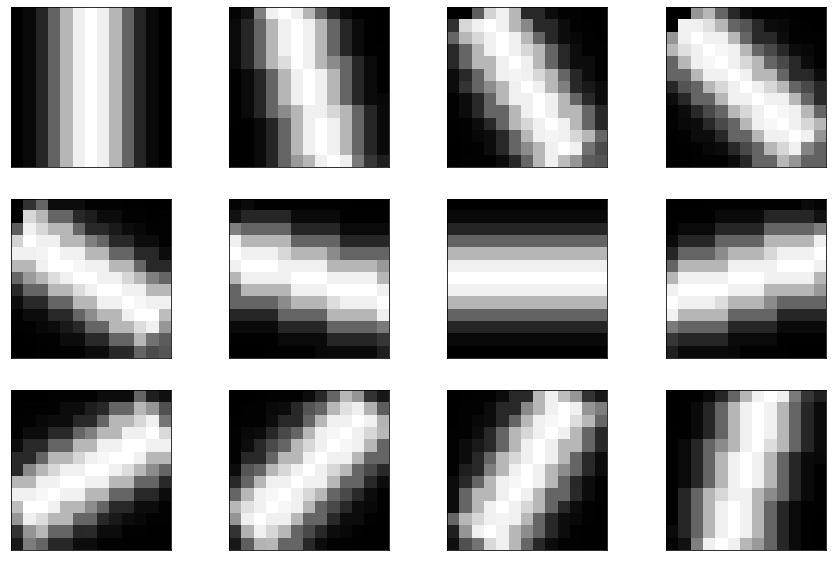

In [544]:
plt.figure(figsize=(15,10))
count = 0
for i in range(3):
    for j in range(4):
        plt.subplot2grid((3,4),(i,j))
        plt.xticks([]), plt.yticks([])
        plt.imshow(GMF(13,2,255,ang*count), 'Greys')
        count += 1

pth = '/Users/damorgal/Documents/Master/Computer_vision/'
plt.savefig(pth+'GMF.JPG')
plt.show()

Familias random de filtros para aplicar algoritmo genético:

In [5]:
def random_filters(T=13, k=255):
    '''
    Función que crea un filtro random de tamaño TxT.
    '''
    # Filtro Random
    x = np.array([np.random.random_sample(T)*k for _ in range(T)])
            
    # Media del kernel
    m = sum(sum(x))/T**2
    # Filtro Random centrado
    x_m = x - m
    
    return x_m

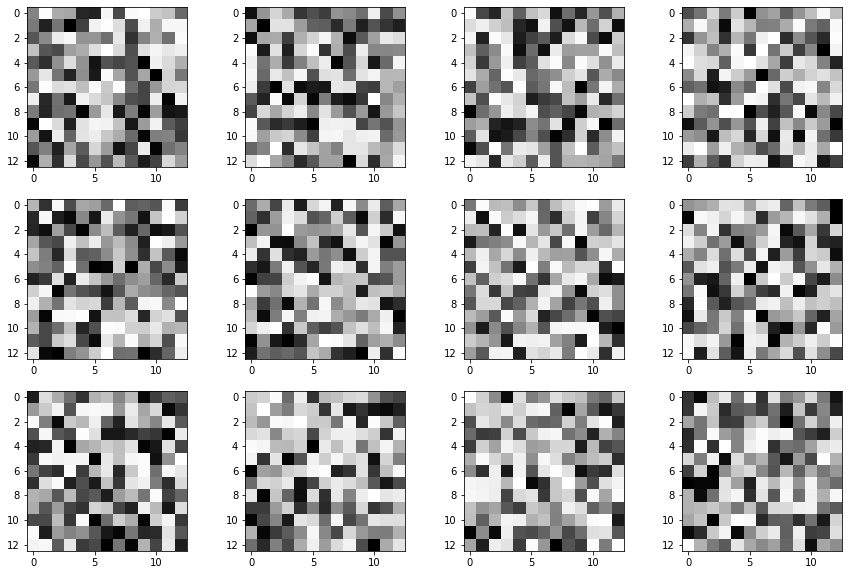

In [6]:
plt.figure(figsize=(15,10))
count = 0
for i in range(3):
    for j in range(4):
        plt.subplot2grid((3,4),(i,j))
        plt.imshow(random_filters(13, 1), 'Greys')
        count += 1
plt.show()

In [574]:
# Tamaño de la población
N = 5
poblacion = []
num_filters = 12
T = 35
sg = 2.5

for p in range(N):
    # Cantidad de filtros por familia
    fam = []
    for i in range(num_filters):
        fam.append(random_filters(T,1))
    poblacion.append(fam)
    
# Agregamos a la familia Gaussiana
gauss = []
angle = np.pi/num_filters
for k in range(num_filters):
    gauss.append(GMF(T, sg, 1, angle*k))
poblacion.append(gauss)
poblacion = np.array(poblacion)
poblacion.shape

(6, 12, 35, 35)

In [154]:
poblacion[-1].shape

(12, 49, 49)

# Algoritmo GMF para los angiogramas:

Probamos primero para la base de datos anterior, recordando que lo que haremos es una convolución con estos filtros y quedarnos con el mayor. Será un ejemplo de una imagen para posteriormente realizar mediciones cuantitativas de toda la base de datos.

Leemos la base de datos:

(2268, 4032)


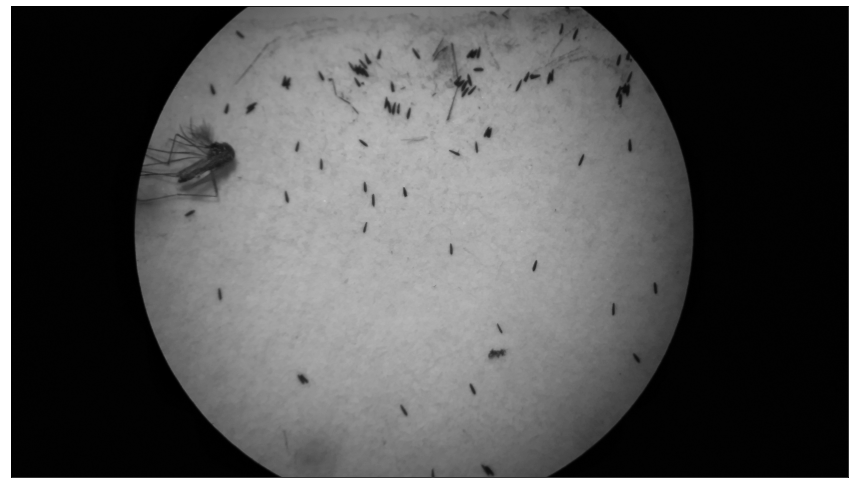

In [96]:
def readpgm(name):
    '''
    Función para leer imágenes en formato PGM
    '''
    with open(name) as f:
        lines = f.readlines()
    # This ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)
    # here,it makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2' 
    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])
    return (np.array(data[3:]),(data[1],data[0]),data[2])

pth = '/Users/damorgal/Documents/Master/Computer_vision/SEG1-A IMG_20220110_102730423 .jpg'
#img = cv2.imread(pth, cv2.IMREAD_GRAYSCALE).astype(float)/255
im = PIL.Image.open(pth)
img = np.array(im.convert("L"))
#img = np.reshape(data[0],data[1])
print(img.shape)
plt.figure(figsize=(15,10))
plt.imshow(img, "binary_r")
plt.xticks([]), plt.yticks([])
plt.show()

(750, 1000)


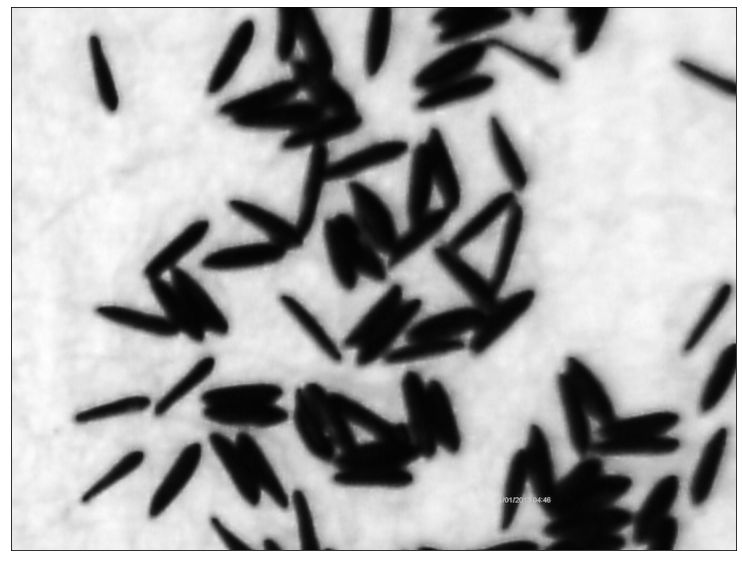

In [591]:
pth = '/Users/damorgal/Documents/Master/Computer_vision/PICT0062.JPG'

#img = cv2.imread(pth, cv2.IMREAD_GRAYSCALE).astype(float)/255
im = PIL.Image.open(pth)
img = np.array(im.convert("L"))
#img = np.reshape(data[0],data[1])
print(img.shape)
plt.figure(figsize=(15,10))
plt.imshow(img, "binary_r")
plt.xticks([]), plt.yticks([])
plt.show()

Función del algoritmo de convolución:

In [97]:
def padding(img, n=3):
    '''
    Función que le hace un padding a una imagen de tamaño n
    '''
    h = len(img)
    w = len(img[0])
    new_img = [[0 for i in range(w+2*n)] for i in range(h+2*n)]
    for i in range(h):
        for j in range(w):
            new_img[n+i][n+j] = img[i,j]
    return np.array(new_img)

def convolve(kernel=[], img=[], center=[]):
    '''
    Función que hace una convolución simple de un kernel dado
    en el centro dado de una imagen.
    '''
    b = len(kernel)//2
    return sum(sum(kernel*img[(center[0]-b):(center[0]+b+1), (center[1]-b):(center[1]+b+1)]))
    #return suma

def match_filters(img, T=13, num_filters=12, kernel=[]):
    '''
    Función que genera 12 tipos de filtros Gaussianos y con cada uno
    realiza una convolución a una imagen, donde para un píxel se queda
    con el valor mayor de cada filtro.
    
    '''
    #Hacemos un padding para hacer posteriormente la convolución
    b = T//2
    img_pad = padding(img, b)
    
    #Algoritmo
    new_img = np.zeros(img.shape)
    for i in range(len(img)):
        for j in range(len(img[0])):
            center = [b+i, b+j]
            max_val = 0
            # Encontrar el mejor filtro
            for k in range(num_filters):
                conv = convolve(kernel[k], img_pad, center)
                if conv > max_val:
                    max_val = conv
            # Nos quedamos con el valor mayor
            new_img[i][j] = max_val
            
    return new_img

Mostramos un ejemplo del resultado con GMF

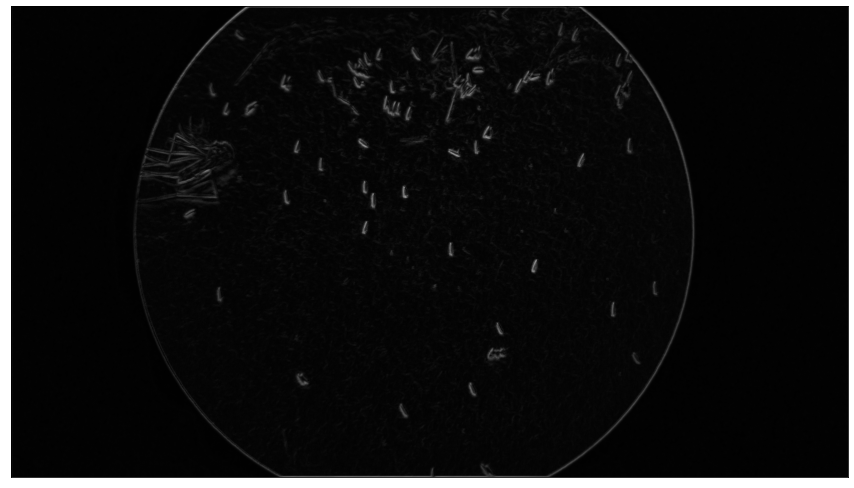

In [56]:
T = 13
sigma = 2
filters = 12

img_matched = match_filters(img, T, filters, poblacion[-2])
plt.figure(figsize=(15,10))
plt.imshow(img_matched, "binary_r")
plt.xticks([]), plt.yticks([])
plt.show()

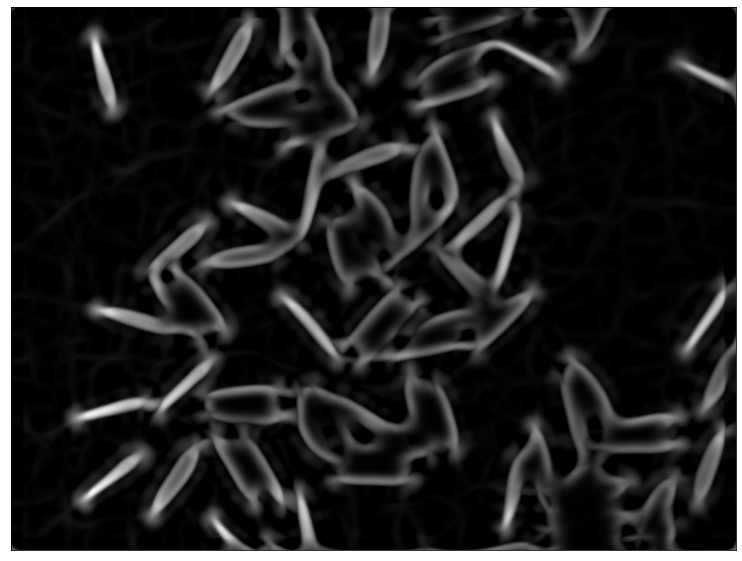

In [592]:
filters = 12

img_matched = match_filters(img, T, filters, poblacion[-1])
plt.figure(figsize=(15,10))
plt.imshow(img_matched, "binary_r")
plt.xticks([]), plt.yticks([])
plt.show()

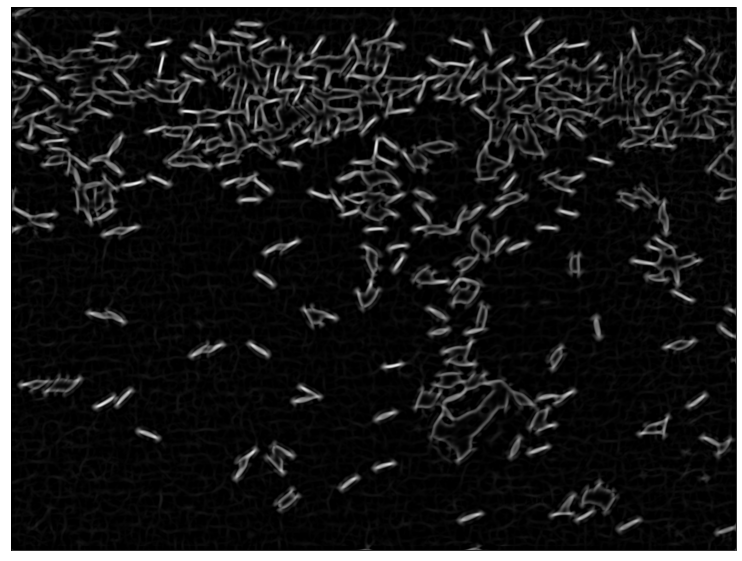

In [132]:
filters = 12


img_matched = match_filters(img, T, filters, poblacion[-1])
plt.figure(figsize=(15,10))
plt.imshow(img_matched, "binary_r")
plt.xticks([]), plt.yticks([])
plt.show()

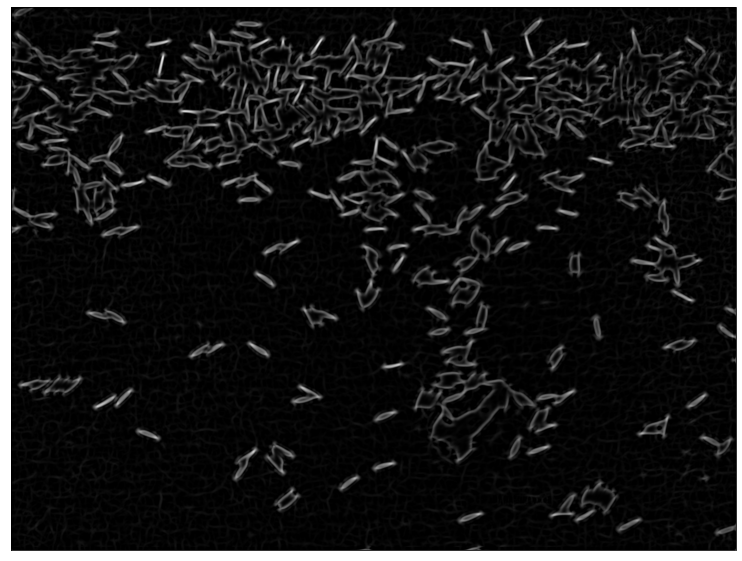

In [125]:
filters = 12


img_matched = match_filters(img, T, filters, poblacion[-1])
plt.figure(figsize=(15,10))
plt.imshow(img_matched, "binary_r")
plt.xticks([]), plt.yticks([])
plt.show()

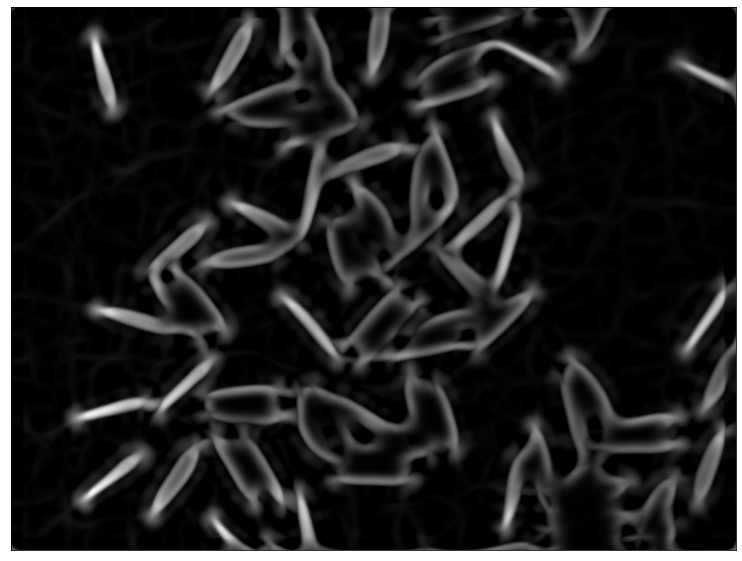

In [593]:
filters = 12


#img_matched = match_filters(img, T, filters, poblacion[-1])
plt.figure(figsize=(15,10))
plt.imshow(img_matched, "binary_r")
plt.xticks([]), plt.yticks([])
plt.imsave(pth+'matched.JPG', img_matched, cmap="binary_r")
plt.show()

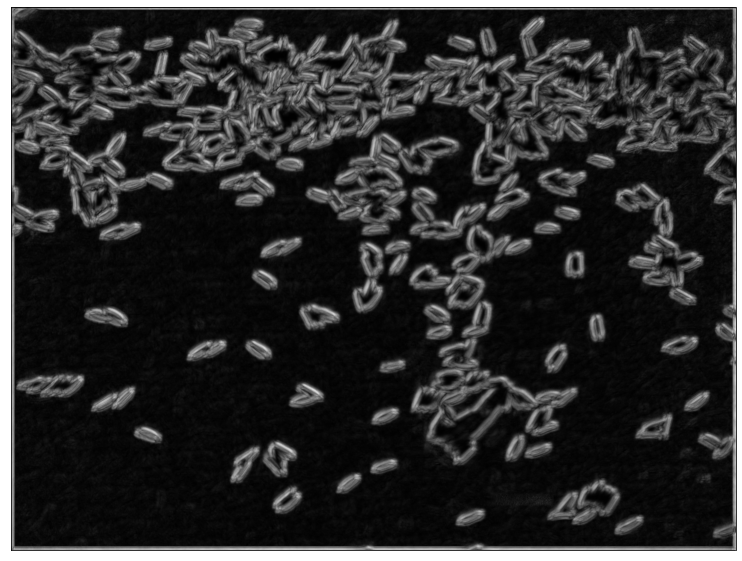

In [110]:
filters = 12

img_matched = match_filters(img, T, filters, poblacion[-2])
plt.figure(figsize=(15,10))
plt.imshow(img_matched, "binary_r")
plt.xticks([]), plt.yticks([])
plt.show()

Ahora, binarizamos la imagen para tener blanco y negro: 

In [99]:
def black_white(img):
    '''
    Función que binariza a blanco y negro una imagen en escala de grises.
    '''
    img_bw = np.zeros(img.shape)
    idx = img > 255/2
    img_bw[idx] = 255
    
    return img_bw

def ridler_calvard(img, tolerance=0.001, n=256):
    img_aux = img*n
    m = np.mean(img_aux) # Initial estimation of the mean
    new_thresh = m
    while(1):
        prev_thresh = new_thresh
        threshold = round(prev_thresh)
        mb = np.mean(img_aux[img_aux <= threshold])
        mo = np.mean(img_aux[img_aux > threshold])
        new_thresh = (mb+mo)/2
        if abs(new_thresh-prev_thresh) <= tolerance:
            break
    return threshold/n

def local_sauvola(img, k=0.5, R=128, b=15):
    '''
    Función del algoritmo de Local Sauvola para encontrar los 
    thresholds adaptables de la imagen y segmentar el fondo.
    
    '''
    #Hacemos un padding para calcular la media y varianza de una ventana de 15x15
    b = b//2
    img_pad = padding(img, b)
    #Algoritmo
    new_img = [[0 for i in range(len(img[0]))] for j in range(len(img))]
    for i in range(len(img)):
        for j in range(len(img[0])):
            center = [b+i, b+j]
            window = [[img_pad[center[0]-b+i2][center[1]-b+j2] for j2 in range(2*b+1)] for i2 in range(2*b+1)]
            #Cálculo de local Sauvola
            threshold = np.mean(window) + (1 + k*(np.std(window)/R - 1))
            #Asignación de color
            if img[i][j] <= threshold:
                new_img[i][j] = 255
    return new_img

La frontera de umbralización encontrada es:
3750.703125

Imagen generada con el threshold


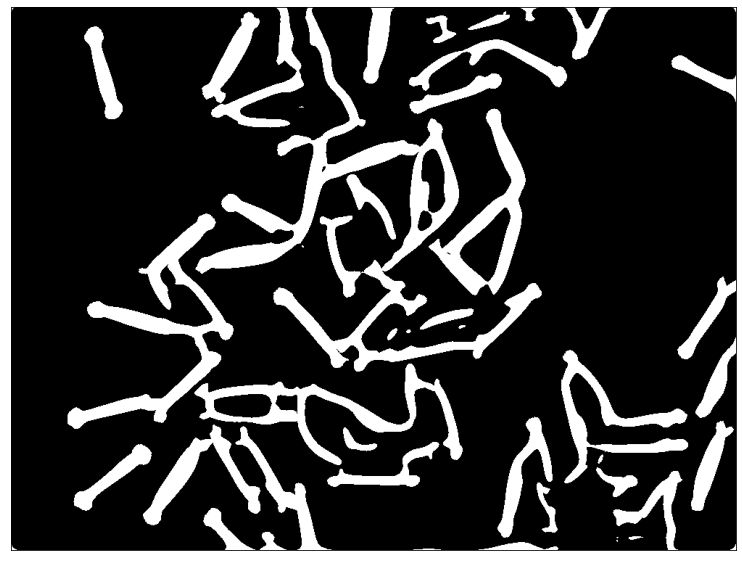

In [594]:
threshold = ridler_calvard(img_matched)
print('La frontera de umbralización encontrada es:\n%f\n' % threshold)
print('Imagen generada con el threshold')
img_rc = np.ones(img_matched.shape)
idx = img_matched <= threshold
img_rc[idx] = 0

plt.figure(figsize=(15,10))
plt.imshow(img_rc, 'binary_r')
plt.xticks([]), plt.yticks([])
plt.imsave(pth+'umbralizadaGMF.JPG', img_rc, cmap='binary_r')
plt.show()

In [595]:
MEAN_AREA = 2650
np.sum(img_rc)// MEAN_AREA

48.0

In [596]:
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd

In [597]:
label_im = label(img_rc)
regions = regionprops(label_im)

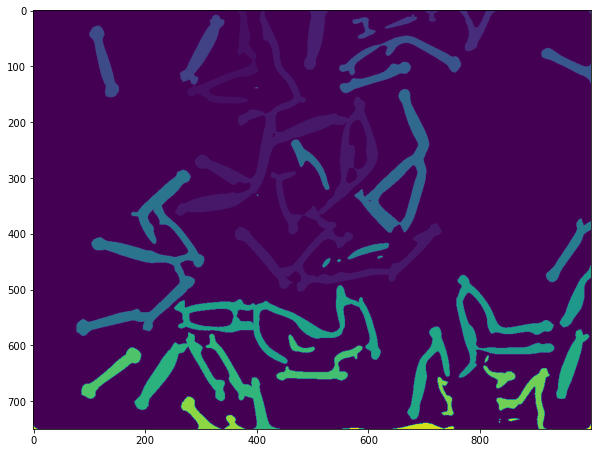

In [598]:
plt.figure(figsize=(10,10))
plt.imshow(label_im)
plt.show()

In [599]:
properties = ['area','convex_area','bbox_area', 'extent',  
              'mean_intensity', 'solidity', 'eccentricity', 
              'orientation']

df = pd.DataFrame(regionprops_table(label_im, img, properties=properties))
df

area  convex_area  bbox_area    extent  mean_intensity  solidity  \
0      27           36         64  0.421875      191.555556  0.750000   
1    4365        13005      21504  0.202985       28.778236  0.335640   
2   32436       139683     240912  0.134638       31.722531  0.232212   
3    2570         3205       4922  0.522145       34.033463  0.801872   
4     278          436        651  0.427035       67.809353  0.637615   
5    1738         3278       5402  0.321733       38.776755  0.530201   
6      27           36         64  0.421875      195.851852  0.750000   
7     495          558       1508  0.328249       14.456566  0.887097   
8    3035         3943      10080  0.301091       47.441516  0.769718   
9     621         1102       1596  0.389098       47.220612  0.563521   
10   2575         3391       6784  0.379570       62.230680  0.759363   
11   3506        10449      15478  0.226515       48.957787  0.335535   
12   1621         2478       5696  0.284586       65.735349  0.654157   
13   2116         2874       7168  0.295201       45.809074  0.736256   
14      9           11         14  0.642857        5.666667  0.818182   
15   8681        20674      34572  0.251099       32.557194  0.419899   
16   1591         2384       6210  0.256200       25.448774  0.667366   
17  13248        43709      68013  0.194786       43.734601  0.303095   
18      7            7          9  0.777778      115.857143  1.000000   
19   2134         3127       9234  0.231102       63.859419  0.682443   
20    818          920       2146  0.381174       11.420538  0.889130   
21     33           37         50  0.660000       11.787879  0.891892   
22    123          129        238  0.516807        7.886179  0.953488   
23     26           27         35  0.742857       47.615385  0.962963   
24   1938         2239       6216  0.311776       33.613519  0.865565   
25   7146        20856      32200  0.221925       29.147635  0.342635   
26  10230        37707      51800  0.197490       29.268328  0.271302   
27   3579         6728      12692  0.281989       40.450964  0.531956   
28   2614         3091       7316  0.357299       37.530222  0.845681   
29   5230        13548      22518  0.232259       40.172275  0.386035   
30   3734         8094      22743  0.164182       35.180771  0.461329   
31    556          882       1551  0.358478       11.897482  0.630385   
32   2528         5514       9610  0.263059       36.098101  0.458469   
33   2452         3592       9936  0.246779       75.709625  0.682628   
34     52           58        104  0.500000       53.884615  0.896552   
35    888         1322       2378  0.373423       30.568694  0.671710   
36   2690         6414      10464  0.257072       22.305948  0.419395   
37    720         1382       2001  0.359820       28.830556  0.520984   
38   1326         1996       4176  0.317529       75.785068  0.664329   
39    430          608        925  0.464865       75.483721  0.707237   
40     63           72        100  0.630000       57.730159  0.875000   
41      4            4          6  0.666667       19.000000  1.000000   
42      5            5          6  0.833333        8.600000  1.000000   
43    630          801       1210  0.520661       17.758730  0.786517   
44     27           36         64  0.421875      193.703704  0.750000   
45     27           36         64  0.421875      199.222222  0.750000   
46     54           64         76  0.710526       41.500000  0.843750   

    eccentricity  orientation  
0       0.858395     0.785398  
1       0.899491    -0.519981  
2       0.568169     0.520245  
3       0.971525    -0.171179  
4       0.581683     0.156842  
5       0.796188    -0.349367  
6       0.858395    -0.785398  
7       0.984563    -1.234993  
8       0.981966    -0.485386  
9       0.774678     0.476803  
10      0.987529     0.257886  
11      0.964476    -1.550304  
12      0.984413     1.117478  
13      0.991628    -1.239910  
14      0.973119    

In [615]:
eggarea = 1700
MINEGG=eggarea/2
MAXEGG = eggarea*2

df2= df[df['area'] > MINEGG]
df2

area  convex_area  bbox_area    extent  mean_intensity  solidity  \
1    4365        13005      21504  0.202985       28.778236  0.335640   
2   32436       139683     240912  0.134638       31.722531  0.232212   
3    2570         3205       4922  0.522145       34.033463  0.801872   
5    1738         3278       5402  0.321733       38.776755  0.530201   
8    3035         3943      10080  0.301091       47.441516  0.769718   
10   2575         3391       6784  0.379570       62.230680  0.759363   
11   3506        10449      15478  0.226515       48.957787  0.335535   
12   1621         2478       5696  0.284586       65.735349  0.654157   
13   2116         2874       7168  0.295201       45.809074  0.736256   
15   8681        20674      34572  0.251099       32.557194  0.419899   
16   1591         2384       6210  0.256200       25.448774  0.667366   
17  13248        43709      68013  0.194786       43.734601  0.303095   
19   2134         3127       9234  0.231102       63.859419  0.682443   
24   1938         2239       6216  0.311776       33.613519  0.865565   
25   7146        20856      32200  0.221925       29.147635  0.342635   
26  10230        37707      51800  0.197490       29.268328  0.271302   
27   3579         6728      12692  0.281989       40.450964  0.531956   
28   2614         3091       7316  0.357299       37.530222  0.845681   
29   5230        13548      22518  0.232259       40.172275  0.386035   
30   3734         8094      22743  0.164182       35.180771  0.461329   
32   2528         5514       9610  0.263059       36.098101  0.458469   
33   2452         3592       9936  0.246779       75.709625  0.682628   
35    888         1322       2378  0.373423       30.568694  0.671710   
36   2690         6414      10464  0.257072       22.305948  0.419395   
38   1326         1996       4176  0.317529       75.785068  0.664329   

    eccentricity  orientation  
1       0.899491    -0.519981  
2       0.568169     0.520245  
3       0.971525    -0.171179  
5       0.796188    -0.349367  
8       0.981966    -0.485386  
10      0.987529     0.257886  
11      0.964476    -1.550304  
12      0.984413     1.117478  
13      0.991628    -1.239910  
15      0.918479    -0.276451  
16      0.973965     0.710374  
17      0.833524    -0.387437  
19      0.989323    -0.569242  
24      0.980436    -0.414352  
25      0.762811     1.121534  
26      0.965219     1.512164  
27      0.963468    -0.353368  
28      0.983335    -0.337362  
29      0.750121    -1.195459  
30      0.983581     0.591671  
32      0.958758    -1.291694  
33      0.987549    -0.900845  
35      0.850239     1.289796  
36      0.632795    -0.798065  
38      0.959433     0.739000

In [616]:
# un solo huevo 
blob = df2['area']
single = df2[(blob>MINEGG) & (blob<MAXEGG)]
print('Número de huevos aislados:', single.shape[0])
clusters=round(blob[blob>eggarea*1.5]/eggarea)
print('Número de huevos en clúters:', sum(clusters))
print('-'*20)
print('TOTAL:', int(single.shape[0]+sum(clusters)))

Número de huevos aislados: 15
Número de huevos en clúters: 64.0
--------------------
TOTAL: 79


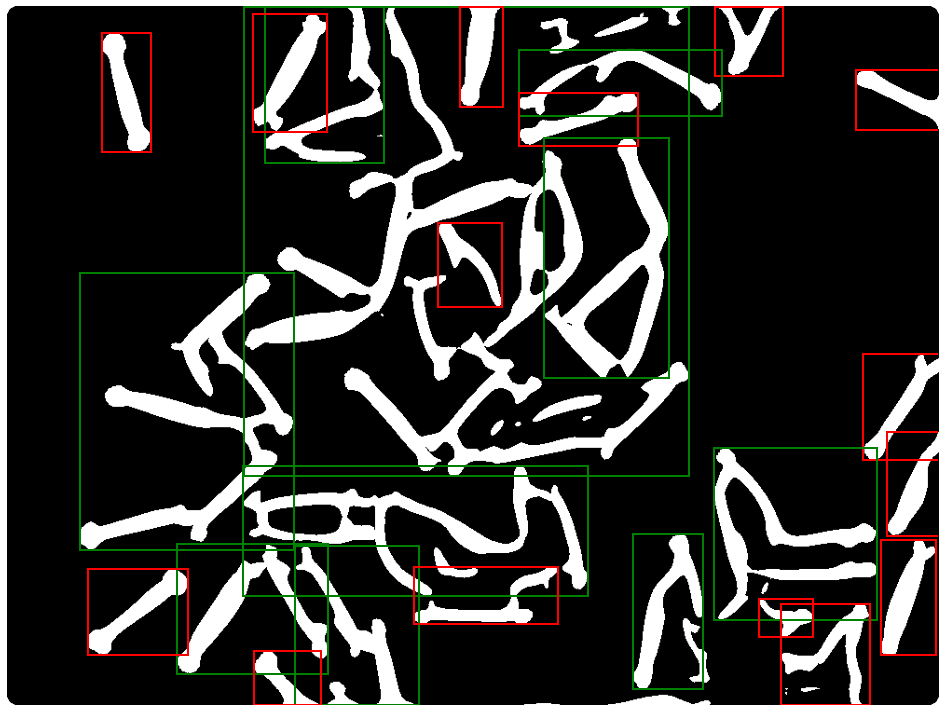

In [617]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(15, 10))
#ax.imshow(opened, 'gray')
ax.imshow(img_rc, 'gray')
MINAREA = min(df2['area'])
for region in regionprops(label_im):
    # take regions with large enough areas
    if region.area >= MINAREA:
        color = 'red' if region.area < MAXEGG else 'green'
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()

plt.savefig(pth + 'deteccion1.JPG')

(3024, 4032)


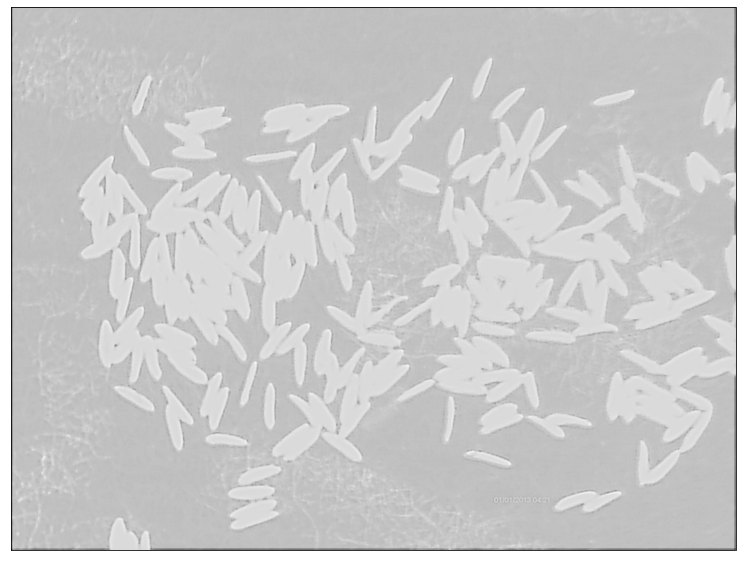

In [520]:
pth = '/Users/damorgal/Documents/Master/Computer_vision/Laplacian_5.JPG'
pth = '/Users/damorgal/Documents/Master/Computer_vision/PICT0049.JPG'
pth = '/Users/damorgal/Documents/Master/Computer_vision/Laplacian_44.JPG'
#img = cv2.imread(pth, cv2.IMREAD_GRAYSCALE).astype(float)/255
im = PIL.Image.open(pth)
img = np.array(im.convert("L"))
#img = np.reshape(data[0],data[1])
print(img.shape)
plt.figure(figsize=(15,10))
plt.imshow(img, "binary_r")
plt.xticks([]), plt.yticks([])
plt.show()

La frontera de umbralización encontrada es:
205.742188

Imagen generada con el threshold


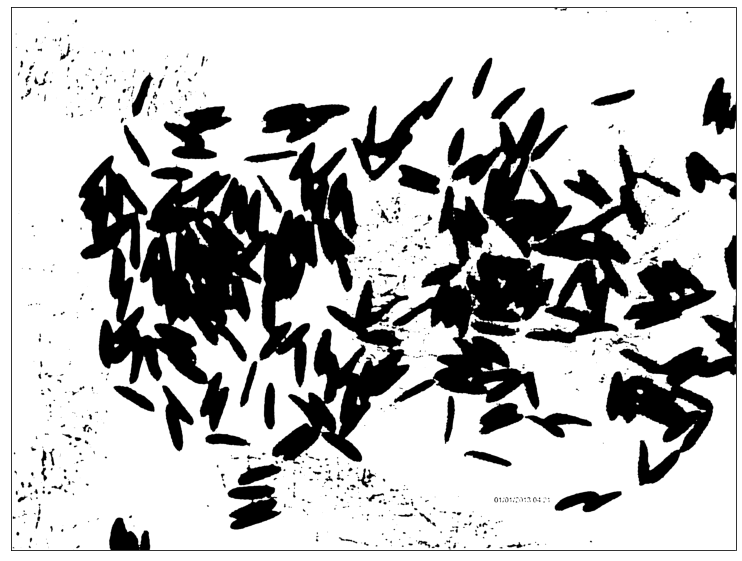

In [521]:
pth = '/Users/damorgal/Documents/Master/Computer_vision/'

threshold = ridler_calvard(img)
print('La frontera de umbralización encontrada es:\n%f\n' % threshold)
print('Imagen generada con el threshold')
img_rc = np.ones(img.shape)
idx = img <= threshold
img_rc[idx] = 0

plt.figure(figsize=(15,10))
plt.imshow(img_rc, 'binary')
plt.imsave(pth + 'umbralizada1.JPG', img_rc, cmap="binary_r")
plt.xticks([]), plt.yticks([])
plt.show()

In [522]:
MEAN_AREA = 2650
np.sum(img_rc)// MEAN_AREA

1236.0

In [523]:
img_rc.shape[0]*img_rc.shape[1]

12192768

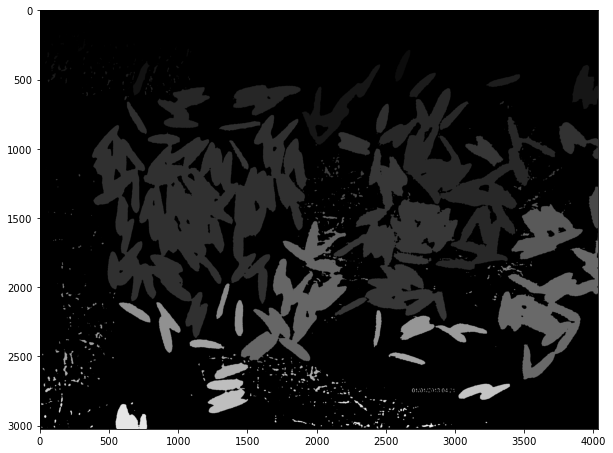

In [524]:
label_im = label(img_rc)
regions = regionprops(label_im)
plt.figure(figsize=(10,10))
plt.imshow(label_im,"gray")
plt.show()

In [525]:
properties = ['area','convex_area','bbox_area', 'extent',  
              'mean_intensity', 'solidity', 'eccentricity', 
              'orientation']

df = pd.DataFrame(regionprops_table(label_im, img, properties=properties))
df

area  convex_area  bbox_area    extent  mean_intensity  solidity  \
0       5            5          5  1.000000      207.600000  1.000000   
1       3            3          3  1.000000      206.000000  1.000000   
2     102          115        162  0.629630      207.039216  0.886957   
3     283          411        608  0.465461      206.579505  0.688564   
4      11           11         12  0.916667      206.000000  1.000000   
..    ...          ...        ...       ...             ...       ...   
920     3            3          3  1.000000      206.000000  1.000000   
921     5            5          6  0.833333      206.200000  1.000000   
922     1            1          1  1.000000      206.000000  1.000000   
923    17           20         24  0.708333      212.411765  0.850000   
924     2            2          2  1.000000      206.000000  1.000000   

     eccentricity  orientation  
0        1.000000     1.570796  
1        1.000000     1.570796  
2        0.865391    -1.455867  
3        0.963636    -1.390974  
4        0.708444    -0.263033  
..            ...          ...  
920      1.000000     0.000000  
921      0.816497     1.249046  
922      0.000000     0.785398  
923      0.988535     1.559061  
924      1.000000     1.570796  

[925 rows x 8 columns]

In [541]:
eggarea = 8500
MINEGG=eggarea/2
MAXEGG = eggarea*2.5

df2= df[df['area'] > MINEGG]
df2

area  convex_area  bbox_area    extent  mean_intensity  solidity  \
43     11016        11620      25764  0.427573      221.534677  0.948021   
66     11051        13006      29640  0.372841      222.481133  0.849685   
80     75402       144532     327714  0.230085      220.035344  0.521698   
81     35952        43405      59466  0.604581      218.243825  0.828292   
102    12197        13242      34547  0.353055      221.334017  0.921084   
106    10462        11326      22264  0.469907      221.895622  0.923715   
137    60035        70671     110062  0.545465      219.193937  0.849500   
140    56272        84111     111888  0.502932      219.243034  0.669021   
149   450584      1088704    1672836  0.269353      218.344025  0.413872   
171    11196        12094      33930  0.329973      221.737317  0.925748   
172    12469        13016      19834  0.628668      220.690673  0.957975   
178  1039861      1970989    2511649  0.414015      219.109073  0.527583   
179    10399        11778      21000  0.495190      221.993461  0.882917   
180    33022        53103      79523  0.415251      218.345315  0.621848   
187    24648        27162      39950  0.616971      219.305623  0.907444   
195    25960        31731      60828  0.426777      218.209476  0.818127   
197     7766         9115      29190  0.266050      221.329127  0.852002   
201   418661       821671    1115868  0.375189      218.298910  0.509524   
267    13480        14779      21186  0.636269      217.874852  0.912105   
322   101172       130940     206000  0.491126      218.171777  0.772659   
371   266083       521047     783618  0.339557      218.843447  0.510670   
385   247645       472767     763488  0.324360      218.533603  0.523820   
495     9168        10134      24832  0.369201      223.593586  0.904677   
522    12870        13477      15799  0.814609      222.313598  0.954960   
523    27476        34437      64225  0.427808      221.125346  0.797863   
524    13251        14003      33288  0.398071      220.871708  0.946297   
539     8615        10005      15694  0.548936      221.986767  0.861069   
542    25767        28127      43824  0.587965      219.407265  0.916095   
562    21317        30990      51986  0.410053      220.830933  0.687867   
585    11533        12678      17821  0.647158      221.808896  0.909686   
599     9358        10995      24024  0.389527      222.843236  0.851114   
627    15648        18269      28674  0.545721      220.053234  0.856533   
688    45701        58246      75000  0.609347      219.910571  0.784620   
713    24112        29663      43524  0.553993      221.440610  0.812865   
832    25331        32184      41040  0.617227      220.224863  0.787068   

     eccentricity  orientation  
43       0.974142    -0.389334  
66       0.978330    -0.374843  
80       0.929990    -0.837790  
81       0.791531     0.098133  
102      0.970262    -0.802607  
106      0.978485    -1.306938  
137      0.915118    -1.398478  
140      0.718343    -0.730283  
149      0.765371     0.591727  
171      0.980048     0.540298  
172      0.943230    -0.281392  
178      0.599274    -1.257378  
179      0.990700    -1.437116  
180      0.838077     1.070076  
187      0.872169     1.179379  
195      0.870793     0.988457  
197      0.987675     0.539424  
201      0.788697     0.036257  
267      0.975254     0.022992  
322      0.671998    -1.003064  
371      0.892502    -0.483379  
385      0.760020    -0.631496  
495      0.989518    -0.288968  
522      0.973893    -0.017735  
523      0.922948     0.165892  
524      0.969274     1.038225  
539      0.988817    -0.107974  
542      0.854016    -1.140742  
562      0.926582     1.554924  
585      0.972303     1.463855  
599      0.987164     1.308749  
627      0.948558    -1.267031  
688      0.522788    -0.946116  
713      0.962714    -1.434746  
832      0.785432     1.226462

In [542]:
# un solo huevo 
blob = df2['area']
single = df2[(blob>MINEGG) & (blob<MAXEGG)]
print('Número de huevos aislados:', single.shape[0])
clusters=round(blob[blob>eggarea*1.5]/eggarea)
print('Número de huevos en clúters:', sum(clusters))
print('-'*20)
print('TOTAL:', int(single.shape[0]+sum(clusters)))

Número de huevos aislados: 16
Número de huevos en clúters: 361.0
--------------------
TOTAL: 377


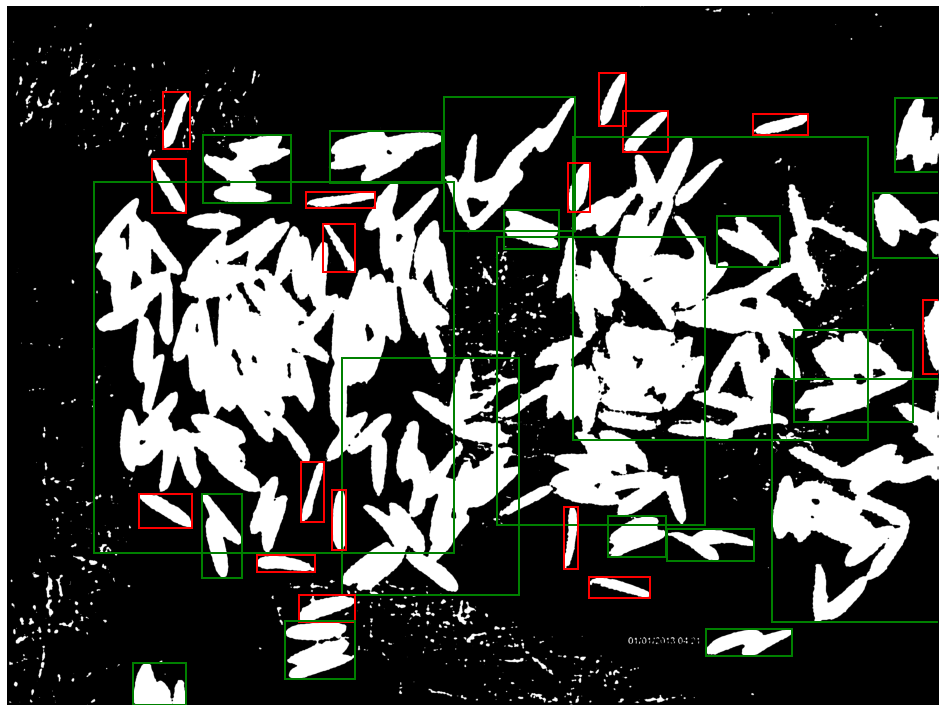

In [543]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(15, 10))
#ax.imshow(opened, 'gray')
ax.imshow(img_rc, 'gray')
MINAREA = min(df2['area'])
for region in regionprops(label_im):
    # take regions with large enough areas
    if region.area >= MINAREA:
        color = 'red' if region.area < MAXEGG else 'green'
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()

plt.savefig(pth + 'deteccion1.JPG')

La frontera de umbralización encontrada es:
4539.765625

Imagen generada con el threshold


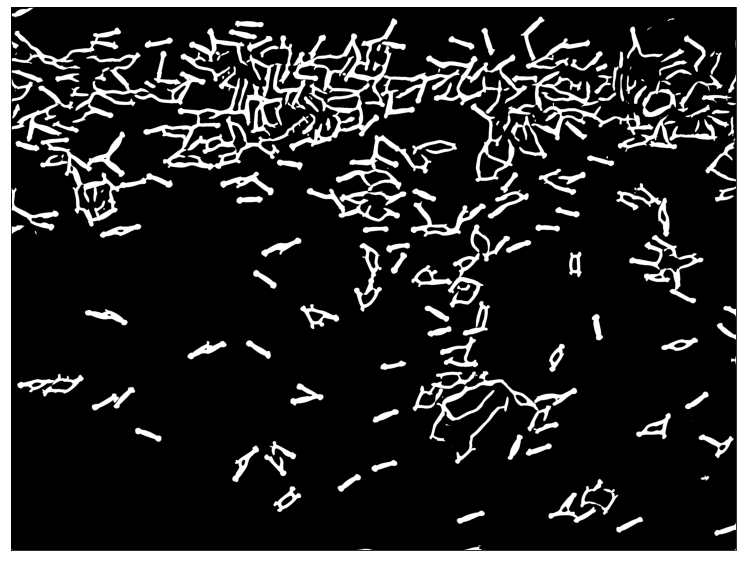

In [346]:
threshold = ridler_calvard(img_matched)
print('La frontera de umbralización encontrada es:\n%f\n' % threshold)
print('Imagen generada con el threshold')
img_rc = np.array([[0 for i in range(len(img_matched[0]))] for j in range(len(img_matched))])
idx = img_matched <= threshold
img_rc[idx] = 255

plt.figure(figsize=(15,10))
plt.imshow(img_rc, 'binary')
plt.xticks([]), plt.yticks([])
plt.show()

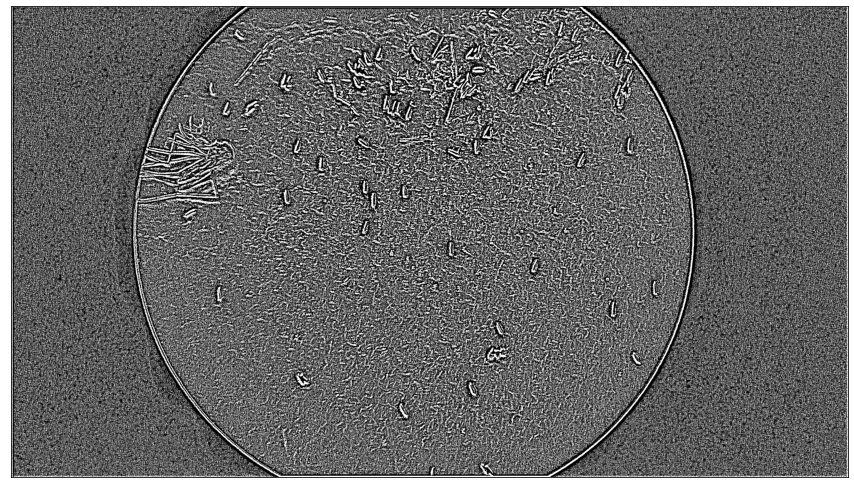

In [76]:
img_ls = local_sauvola(img_matched)

plt.figure(figsize=(15,10))
plt.imshow(img_ls, 'binary')
plt.xticks([]), plt.yticks([])
plt.show()

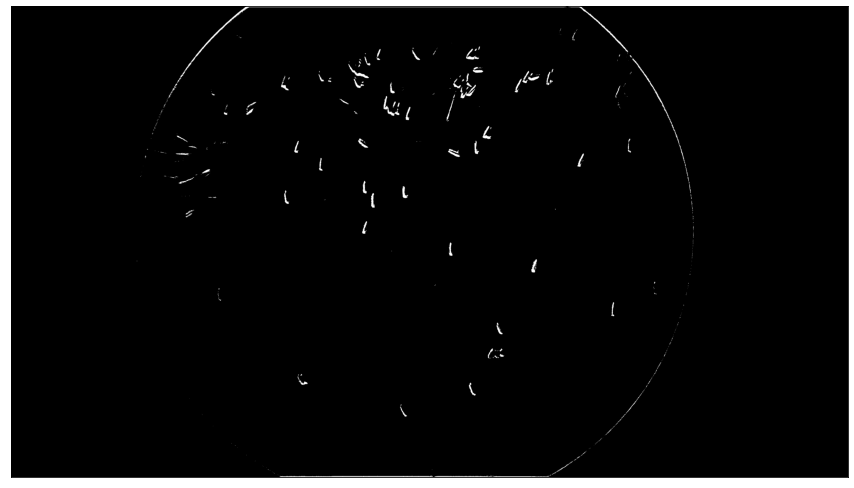

In [85]:
img_matched_bw = black_white(img_matched)

plt.figure(figsize=(15,10))
plt.imshow(img_matched_bw, 'binary_r')
plt.xticks([]), plt.yticks([])
plt.show()

In [102]:
def GA(poblacion=[], generations=10, reproduction=3, imgs=[], img_gt=[], T=13, filters=12):
    '''
    Algoritmo Genético para encontrar mejor familia de filtros.
    '''
    n_train = len(imgs)
    n_pob = len(poblacion)
    best_pob = 0
    
    for g in range(generations):
        ac_m = []
        for p in range(n_pob):
            acs = []
            for i in range(n_train):
                img_matched = black_white( match_filters(imgs[i], T, filters, poblacion[p]) ) 
                met = metrics(img_matched, img_gt[i])
                acs.append(accuracy(met[0], met[1], met[2], met[3]))
            ac_m.append( (np.mean(acs), p) )
        # Paso de selección genética 
        ac_m.sort()
        #Mejores
        best_pob = ac_m[-1][1]
        for i in range(reproduction):
            birth = (poblacion[ac_m[-1-2*i][1]] + poblacion[ac_m[-2-2*i][1]])/2
            poblacion[ac_m[i][1]] = birth
        print('Generación %d realizada.' % (g+1))
    return poblacion[best_pob]

In [160]:
best_filters = GA(poblacion, 10, 2, imgs[:30], imgs_gt[:30], 13, 12)

Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Generación 6 realizada.
Generación 7 realizada.
Generación 8 realizada.
Generación 9 realizada.
Generación 10 realizada.


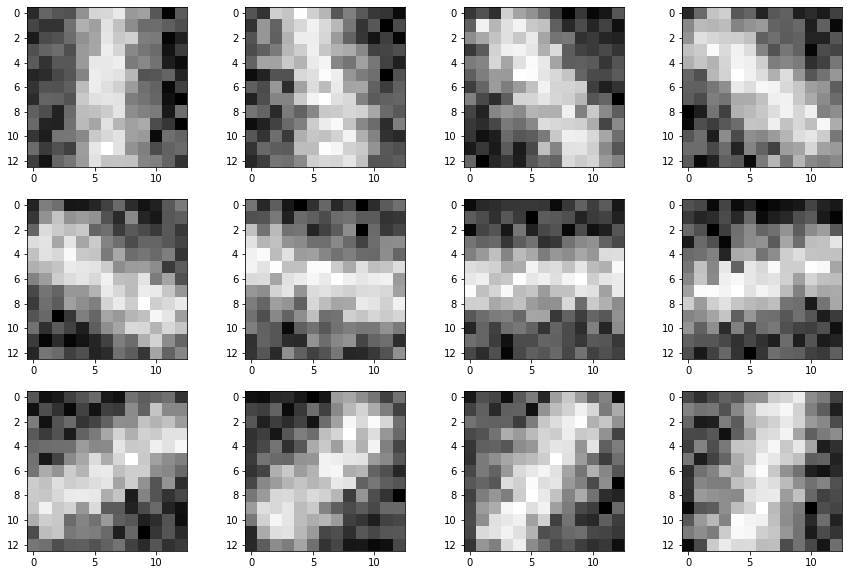

In [185]:
plt.figure(figsize=(15,10))
count = 0
for i in range(3):
    for j in range(4):
        plt.subplot2grid((3,4),(i,j))
        plt.imshow(best_filters[count], 'Greys')
        count += 1
plt.show()

In [177]:
img_matched = black_white( match_filters(imgs[50], T, filters, best_filters) ) 

Imagen generada con GMF.				Imagen del Ground Truth


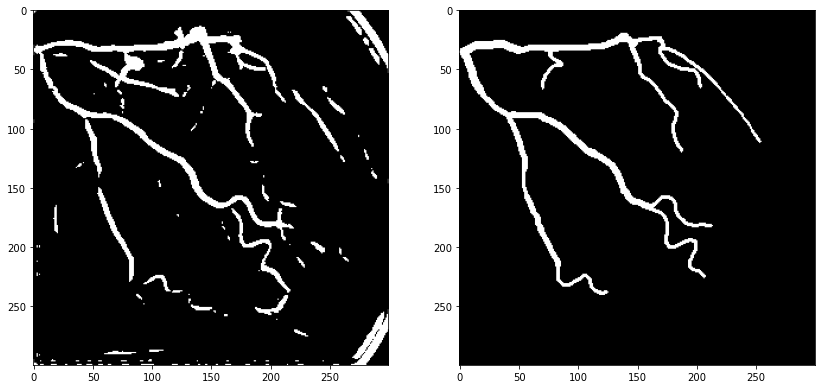

In [181]:
data = readpgm(pth + '51_gt.pgm')
img_gt = np.reshape(data[0],data[1])
print('Imagen generada con GMF.\t\t\t\tImagen del Ground Truth')
plt.figure(figsize=(14,20))
plt.subplot(121)
plt.imshow(img_matched, 'binary_r')
plt.subplot(122)
plt.imshow(img_gt, 'binary_r')
plt.show()

Lo evaluamos de manera cuantitativa:

In [166]:
def metrics(img, img_gt):
    '''
    Función que regresa las siguientes cantidades de una imagen:
        True Positives  : tp 
        True Negatives  : tn
        False Positives : fp
        False Negatives : fn
    ordenados en una lista de la forma [tp, tn, fp, fn]
    '''
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img_gt[i][j]==255 and img[i][j]==255:
                tp += 1
            elif img_gt[i][j]==0 and img[i][j]==0:
                tn += 1
            elif img_gt[i][j]==0 and img[i][j]==255:
                fp += 1
            elif img_gt[i][j]==255 and img[i][j]==0:
                fn += 1
    return [tp, tn, fp, fn]

def sensitivity(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fn)

def specificity(tp=0, tn=0, fp=0, fn=0):
    return tn/(tn+fp)

def accuracy(tp=0, tn=0, fp=0, fn=0):
    return (tp+tn)/(tp+tn+fp+fn)

def pos_pred_val(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fp)

def neg_pred_val(tp=0, tn=0, fp=0, fn=0):
    return tn/(tn+fn)

def matthews_cc(tp=0, tn=0, fp=0, fn=0):
    return ((tp*tn) - (fp*fn))/((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**(1/2)

def jaccard(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fn+fp)

def dice(tp=0, tn=0, fp=0, fn=0):
    return 2*tp/(2*tp+fn+fp)

In [183]:
angio_metrics = metrics(img_matched, img_gt)
print('Métricas para la imagen generada por GMF:')
print('Sensitivity: \t\t\t\t%.3f' % sensitivity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Specificity: \t\t\t\t%.3f' % specificity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Accuracy: \t\t\t\t%.3f' % accuracy(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Positive Predictive Value: \t\t%.3f' % pos_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Negative Predictive Value: \t\t%.3f' % neg_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Matthews Correlation Coefficient: \t%.3f' % matthews_cc(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Jaccard Index: \t\t\t\t%.3f' % jaccard(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Dice Coefficient: \t\t\t%.3f' % dice(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))

Métricas para la imagen generada por GMF:
Sensitivity: 				0.802
Specificity: 				0.957
Accuracy: 				0.949
Positive Predictive Value: 		0.498
Negative Predictive Value: 		0.989
Matthews Correlation Coefficient: 	0.608
Jaccard Index: 				0.444
Dice Coefficient: 			0.615


Se obtiene un gran desempeño con un accuracy de 0.81.

Ahora, leemos todas las imágenes de la base de datos y reportaremos el promedio de las métricas totales de la base de datos.

In [95]:
#En total son 134 imágenes a leer
imgs = []
imgs_gt = []
for i in range(134):
    data = readpgm(pth + str(i+1) + '.pgm')
    img_aux = np.reshape(data[0],data[1])
    imgs.append(img_aux)
    data = readpgm(pth + str(i+1) + '_gt' + '.pgm')
    img_aux = np.reshape(data[0],data[1])
    imgs_gt.append(img_aux)

In [174]:
T = 13
sigma = 2
filters = 12
angio_metrics_tot = []

for i in range(100,134):
    img_ls = black_white( match_filters(imgs[i], T, filters, best_filters) ) 
    #Metricas
    angio_metrics = metrics(img_ls, imgs_gt[i])
    metrics_aux = [sensitivity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   specificity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   accuracy(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   pos_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   neg_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   matthews_cc(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   jaccard(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   dice(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3])]
    angio_metrics_tot.append(metrics_aux)

In [175]:
angio_metrics_tot_mean = np.mean(angio_metrics_tot, axis=0)
print('Promedios de las métricas:\n\n')
print('Métricas del algoritmo de GMF:')
print('Sensitivity: \t\t\t\t%.3f' % angio_metrics_tot_mean[0])
print('Specificity: \t\t\t\t%.3f' % angio_metrics_tot_mean[1])
print('Accuracy: \t\t\t\t%.3f' % angio_metrics_tot_mean[2])
print('Positive Predictive Value: \t\t%.3f' % angio_metrics_tot_mean[3])
print('Negative Predictive Value: \t\t%.3f' % angio_metrics_tot_mean[4])
print('Matthews Correlation Coefficient: \t%.3f' % angio_metrics_tot_mean[5])
print('Jaccard Index: \t\t\t\t%.3f' % angio_metrics_tot_mean[6])
print('Dice Coefficient: \t\t\t%.3f' % angio_metrics_tot_mean[7])

Promedios de las métricas:


Métricas del algoritmo de GMF:
Sensitivity: 				0.732
Specificity: 				0.961
Accuracy: 				0.949
Positive Predictive Value: 		0.522
Negative Predictive Value: 		0.984
Matthews Correlation Coefficient: 	0.587
Jaccard Index: 				0.431
Dice Coefficient: 			0.598


Notamos que para la base de datos de los angiogramas, logra un muy buen desempeño logrando un accuracy promdeio de 0.74 en todas las imágenes de ground truth.

Siguiente paso es probar que tan bien funciona el algoritmo con la base de datos de la retina.

# GMF en datos de Retina

Hacemos una prueba para una imagen dada de ejemplo:

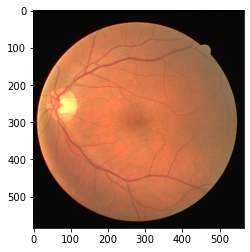

In [186]:
pth = 'DRIVE_retina/training/images/'
img = plt.imread(pth + '21_training.tif')
plt.imshow(img, 'Greys_r')
plt.show()

Para trabajar, necesitamos convertir la imagen a escala de grises:

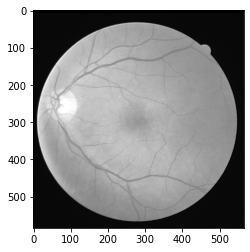

In [187]:
ra = np.array(img[:, :, 0])
ga = np.array(img[:, :, 1])
ba = np.array(img[:, :, 2])

img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
plt.imshow(img_gray, 'Greys_r')
plt.show()

Mostramos un ejemplo de GMF:

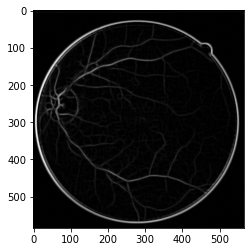

In [190]:
T = 13
sigma = 2
filters = 12

img_matched = match_filters(img_gray, T, filters, best_filters)
plt.imshow(img_matched, 'Greys_r')
plt.show()

LA binarizamos a solamente blanco y negro:

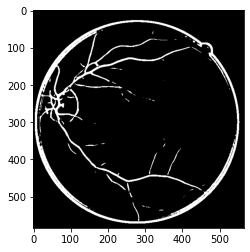

In [191]:
img_matched_bw = black_white(img_matched)
plt.imshow(img_matched_bw, 'binary_r')
plt.show()

Comparamos con el ground truth:

Imagen generada con GMF.				Imagen del Ground Truth


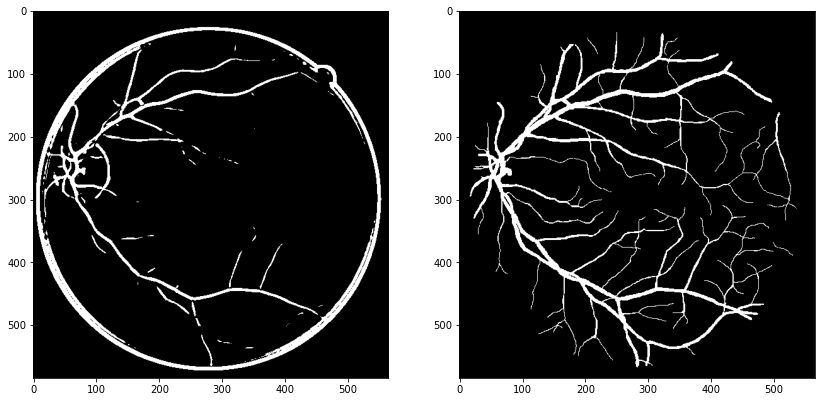

In [192]:
pth = 'DRIVE_retina/training/1st_manual/'
img_gt = plt.imread(pth + '21_manual1.gif')
print('Imagen generada con GMF.\t\t\t\tImagen del Ground Truth')
plt.figure(figsize=(14,20))
plt.subplot(121)
plt.imshow(img_matched_bw, 'binary_r')
plt.subplot(122)
plt.imshow(img_gt, 'binary_r')
plt.show()

Resultado cuantitativo:

In [193]:
retina_metrics = metrics(img_matched_bw, img_gt)
print('Métricas para la imagen generada por GMF:')
print('Sensitivity: \t\t\t\t%.3f' % sensitivity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Specificity: \t\t\t\t%.3f' % specificity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Accuracy: \t\t\t\t%.3f' % accuracy(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Positive Predictive Value: \t\t%.3f' % pos_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Negative Predictive Value: \t\t%.3f' % neg_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Matthews Correlation Coefficient: \t%.3f' % matthews_cc(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Jaccard Index: \t\t\t\t%.3f' % jaccard(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Dice Coefficient: \t\t\t%.3f' % dice(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))

Métricas para la imagen generada por GMF:
Sensitivity: 				0.370
Specificity: 				0.947
Accuracy: 				0.904
Positive Predictive Value: 		0.361
Negative Predictive Value: 		0.949
Matthews Correlation Coefficient: 	0.314
Jaccard Index: 				0.224
Dice Coefficient: 			0.366


El cual es un resultado similarmente bueno que con los angiogramas, logrando un accuracy de 0.75 en la imagen de prueba.

Finalmente, realizamos la deteccion de bordes con GMF para toda la base de datos de la retina (incluyendo training y test) para después reportar el valor promedio de las metricas obtenidas en cada imagen.

In [199]:
#Imágenes a leer
imgs = []
imgs_gt = []
pth = 'DRIVE_retina/training/'
for i in range(20):
    img_aux = plt.imread(pth + 'images/' + str(i+21) + '_training.tif')
    ra = np.array(img_aux[:, :, 0])
    ga = np.array(img_aux[:, :, 1])
    ba = np.array(img_aux[:, :, 2])
    img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
    imgs.append(img_gray)
    img_aux = plt.imread(pth + '1st_manual/' + str(i+21) + '_manual1.gif')
    imgs_gt.append(img_aux)
pth = 'DRIVE_retina/test/'
for i in range(9):
    img_aux = plt.imread(pth + 'images/0' + str(i+1) + ' test.tif')
    ra = np.array(img_aux[:, :, 0])
    ga = np.array(img_aux[:, :, 1])
    ba = np.array(img_aux[:, :, 2])
    img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
    imgs.append(img_gray)
    img_aux = plt.imread(pth + '1st_manual/0' + str(i+1) + '_manual1.gif')
    imgs_gt.append(img_aux)
for i in range(11):
    img_aux = plt.imread(pth + 'images/' + str(i+10) + ' test.tif')
    ra = np.array(img_aux[:, :, 0])
    ga = np.array(img_aux[:, :, 1])
    ba = np.array(img_aux[:, :, 2])
    img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
    imgs.append(img_gray)
    img_aux = plt.imread(pth + '1st_manual/' + str(i+10) + '_manual1.gif')
    imgs_gt.append(img_aux)

In [200]:
# Tamaño de la población
N = 5
poblacion2 = []
num_filters = 12

for p in range(N):
    # Cantidad de filtros por familia
    fam = []
    for i in range(num_filters):
        fam.append(random_filters(13,1))
    poblacion2.append(fam)
    
# Agregamos a la familia Gaussiana
gauss = []
angle = np.pi/num_filters
for k in range(num_filters):
    gauss.append(GMF(13, 2, 1, angle*k))
poblacion2.append(gauss)
poblacion2 = np.array(poblacion2)

In [ ]:
best_filters2 = GA(poblacion2, 10, 2, imgs[:20], imgs_gt[:20], 13, 12)

Generación 1 realizada.
Generación 2 realizada.


In [ ]:
plt.figure(figsize=(15,10))
count = 0
for i in range(3):
    for j in range(4):
        plt.subplot2grid((3,4),(i,j))
        plt.imshow(best_filters2[count], 'Greys')
        count += 1
plt.show()

In [ ]:
img_matched = black_white( match_filters(imgs[25], T, num_filters, best_filters2) ) 

In [ ]:
pth = 'DRIVE_retina/test/1st_manual/'
img_gt = plt.imread(pth + '01_manual1.gif')
print('Imagen generada con GMF.\t\t\t\tImagen del Ground Truth')
plt.figure(figsize=(14,20))
plt.subplot(121)
plt.imshow(img_matched, 'binary_r')
plt.subplot(122)
plt.imshow(img_gt, 'binary_r')
plt.show()

In [ ]:
retina_metrics = metrics(img_matched, img_gt)
print('Métricas para la imagen generada por GMF:')
print('Sensitivity: \t\t\t\t%.3f' % sensitivity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Specificity: \t\t\t\t%.3f' % specificity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Accuracy: \t\t\t\t%.3f' % accuracy(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Positive Predictive Value: \t\t%.3f' % pos_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Negative Predictive Value: \t\t%.3f' % neg_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Matthews Correlation Coefficient: \t%.3f' % matthews_cc(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Jaccard Index: \t\t\t\t%.3f' % jaccard(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Dice Coefficient: \t\t\t%.3f' % dice(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))

In [ ]:
T = 13
retina_metrics_tot = []

for i in range(20,40):
    #ra = np.array(imgs[i][:, :, 0])
    #ga = np.array(imgs[i][:, :, 1])
    #ba = np.array(imgs[i][:, :, 2])

    #img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
    #img_ls = match_filters(img_gray, T, sigma, filters)
    #img_ls = black_white(img_ls)
    img_ls = black_white( match_filters(imgs[i], T, num_filters, best_filters2) )
    #Metricas
    retina_metrics = metrics(img_ls, imgs_gt[i])
    metrics_aux = [sensitivity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   specificity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   accuracy(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   pos_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   neg_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   matthews_cc(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   jaccard(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   dice(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3])]
    retina_metrics_tot.append(metrics_aux)

In [ ]:
retina_metrics_tot_mean = np.mean(retina_metrics_tot, axis=0)
print('Promedios de las métricas:\n\n')
print('Métricas del algoritmo :')
print('Sensitivity: \t\t\t\t%.3f' % retina_metrics_tot_mean[0])
print('Specificity: \t\t\t\t%.3f' % retina_metrics_tot_mean[1])
print('Accuracy: \t\t\t\t%.3f' % retina_metrics_tot_mean[2])
print('Positive Predictive Value: \t\t%.3f' % retina_metrics_tot_mean[3])
print('Negative Predictive Value: \t\t%.3f' % retina_metrics_tot_mean[4])
print('Matthews Correlation Coefficient: \t%.3f' % retina_metrics_tot_mean[5])
print('Jaccard Index: \t\t\t\t%.3f' % retina_metrics_tot_mean[6])
print('Dice Coefficient: \t\t\t%.3f' % retina_metrics_tot_mean[7])

El cual, logra subir el accuracy a 0.76.

Como conclusión de este reporte se logra notar que el método de los filtros Gaussianos es una excelente idea pues al tener cada filtro la forma de arteria y al rotar cada filtro, se logra captar de manera eficiente a la arteria y cualquier otro borde parecido a él. Se obtienen resultados satisfactorios, pues a pesar de que para la retina se obtiene un accuracy de .76, esto es casi seguramente debido a que se detecta el borde ocular y en las imagenes del ground truth no existe. Además, notamos que en la retina hay arterias más delgadas por lo que se optó por jugar con varios tamaños de filtro, ganando aún así el de tamño 13. Una propuesta a futuro es: así como se variaba el ángulo de rotación del filtro, también se debe variar los varios tamaños del filtro y quedarse con el de mayor convolución, pues así se detectará mejor arterias delgadas y gruesas.